# [OpenCV-Python Tutorial] Classification

In this notebook, we will learn how to perform Object Classification using Visual Bag of Words(VBoW), spatial histogram feature, and SVM classifier.

---

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import os, sys
import tarfile
import time
import random
# import cPickle as pickle
import pickle as pk

In [2]:
caltech_url = 'http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz'
caltech_filename = '101_ObjectCategories.tar.gz'
caltech_dir = '101_ObjectCategories/'

numTrain = 15
numTest = 15
numClasses = 102
numWords = 600

vocabPath = os.path.join(caltech_dir, 'vocab.pkl')
svmPath = os.path.join(caltech_dir, 'svm_data.dat')

# Dataset

## 1. Download Caltech-101 dataset

In [3]:
def download_file(url, path):
    import urllib.request
    file_name = url.split('/')[-1]
    u = urllib.request.urlopen(url)
    f = open(os.path.join(path, file_name), 'wb')
    meta = u.info()
    file_size = int(meta.getheaders("Content-Length")[0])
    print("Downloading: %s Bytes: %s" % (file_name, file_size))

    download_size = 0
    block_size = 8192
    while True:
        buf = u.read(block_size)
        if not buf:
            break
        download_size += len(buf)
        f.write(buf)
        status = "\r%12d  [%3.2f%%]" % (download_size, download_size * 100. / file_size)
        print(status,)
        sys.stdout.flush()
    f.close()

if not os.path.exists(caltech_dir) or not os.path.exists(os.path.join(caltech_dir, 'airplanes')):
    print('Downloading Caltech-101')
    if not os.path.exists(caltech_filename) or os.path.getsize(caltech_filename) != 131740031:
        download_file(caltech_url, '.')
    print('Extracting Caltech-101')
    with tarfile.open(caltech_filename) as tar:
        tar.extractall()

print('Caltech-101 dataset checked')

Extracting Caltech-101
Caltech-101 dataset checked


## 2. Setup Data

Select 15 train/test images for each class
done


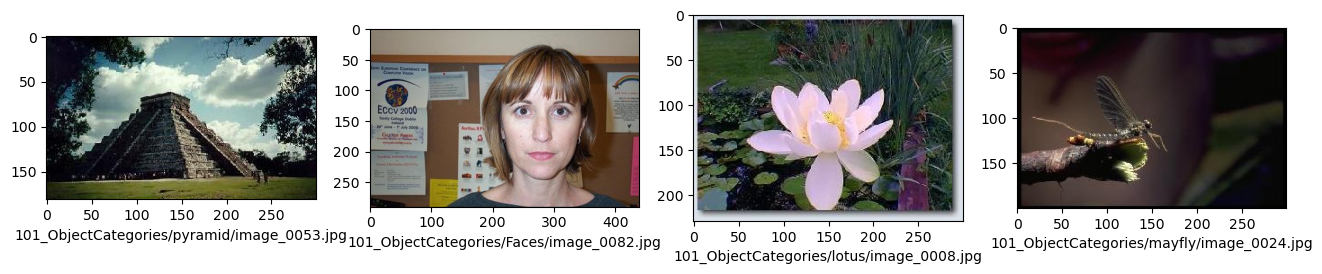

In [4]:
# Select 15 train/test images for each class
print('Select 15 train/test images for each class')
classes = os.walk(caltech_dir).__next__()[1]
train_image_ll = []
test_image_ll = []
for c in classes:
    class_dir = os.path.join(caltech_dir, c)
    ims = [f for f in os.walk(class_dir).__next__()[2] if f.endswith('.jpg')]
    random.shuffle(ims)
    train_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[:numTrain]])
    test_image_ll.append([os.path.join(caltech_dir,c,f) for f in ims[numTrain:numTrain+numTest]])
print('done')

# Show 4 random images
plt.figure(figsize=(16,4))
for i, idx in enumerate(random.sample(range(len(classes)), 4)):
    fpath = random.sample(train_image_ll[idx], 1)[0]
    plt.subplot(1, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel(fpath)

# Dense SIFT(PHOW) and Visual Words

## 1. SIFT helper functions

In [5]:
sift = cv2.SIFT_create()

# Resize a image if it's too large
def standarizeImage(img):
    rows, cols = img.shape
    if cols > 480:
        img = cv2.resize(img, (480, int(rows*480/cols)))
    return img

# Detect and extract SIFT from a single image
def SIFT(img):
    kp, des = sift.detectAndCompute(img, None)
    return des

# Load an image + Resize if large + Extract SIFT
def SIFT2(img_fpath):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    kp, des = sift.detectAndCompute(img, None)
    return SIFT(img)

# Dense SIFT(Extract SIFT descriptor in grid points over an image)
def denseSIFT(img, step = 5, size = 7):
    rows, cols = img.shape[:2]
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    return des

# Load an image + Resize if large + Dense SIFT
def denseSIFT2(img_fpath, step = 10):
    img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)
    img = standarizeImage(img)
    return denseSIFT(img, step)

## 2. Visual Words(Train Vocabulary)

In [6]:
# Train vocabulary
if not os.path.exists(vocabPath):
    # Get PHOW features from 30 random training image to build a dictionary
    print("Extracting PHOW features some training images...")
    PHOW_descrs = []
    temp = [item for sublist in train_image_ll for item in sublist]
    temp = random.sample(temp, 30)
    for fpath in temp:
        des = denseSIFT2(fpath)
        PHOW_descrs.append(des)
    PHOW_descrs = np.concatenate(PHOW_descrs, axis=0)
    print("Total %d PHOW features" % PHOW_descrs.shape[0])
    
    # Quantize the descriptors to get the visual words
    print("Running K-means clustering (%d -> %d)..." % (PHOW_descrs.shape[0], numWords))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 500, 1.0)
    attempts = 10
    flags = cv2.KMEANS_RANDOM_CENTERS
    start_time = time.time()
    retval, bestLabels, vocab = cv2.kmeans(PHOW_descrs, numWords, None, criteria, attempts, flags)
    print('Elapsed time: %.6fs' % (time.time() - start_time))
    
    print('Saving...' )
    with open(vocabPath,'wb') as fd:
        pk.dump(vocab, fd)
else:
    print("Load the trained visual words...")
    with open(vocabPath,'rb') as fd:
        vocab = pk.load(fd)
print('Done!')

Extracting PHOW features some training images...
Total 19064 PHOW features
Running K-means clustering (19064 -> 600)...
Elapsed time: 72.264164s
Saving...
Done!


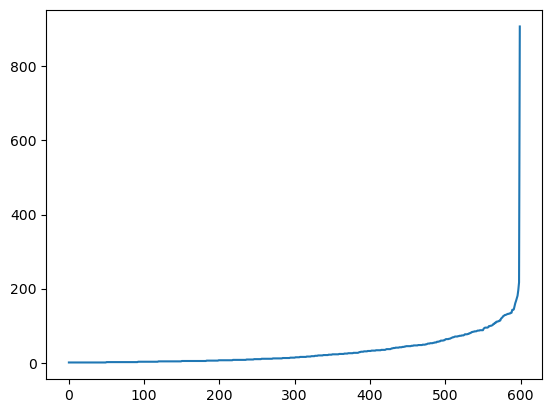

In [7]:
import collections
myCounter = collections.Counter(bestLabels.flatten())
plt.plot(sorted(myCounter.values()))

# Classification - SVM

## Spatial Histogram

In [8]:
bf = cv2.BFMatcher()

def getImageDescriptor(img, step=5, size=7):
    img = standarizeImage(img)
    cols, rows = img.shape[:2]
    
    # Extracting denseSIFT and BoW
    kp = []
    for x in range(step,cols,step):
        for y in range(step,rows,step):
            kp.append(cv2.KeyPoint(x, y, size))
    kp, des = sift.compute(img, kp)
    matches = bf.knnMatch(des, vocab, k=1)
    words = [m[0].trainIdx for m in matches]
    
    # Spatial Binning - 2x2
    binX = 2; binY = 2;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = (int)(k.pt[0]) * binX / cols
        j = (int)(k.pt[1]) * binY / rows
        i = int(i)
        j = int(j)
        w = int(w)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = temp
    
    # Spatial Binning - 4x4
    binX = 4; binY = 4;
    temp = np.zeros((binX, binY, numWords), dtype=np.float32)
    for k, w in zip(kp, words):
        i = (int)(k.pt[0]) * binX / cols
        j = (int)(k.pt[1]) * binY / rows
        i = int(i)
        j = int(j)
        w = int(w)
        temp[i, j, w] += 1
    for i in range(binX):
        for j in range(binY):
            temp[i, j, :] /= np.sum(temp[i, j, :])
    temp = temp.flatten()
    hist = np.concatenate((hist, temp), axis=0)
    
    hist /= np.sum(hist)
    return hist    

## 1. Genarate spatial histogram for Training Images

In [9]:
# Extract spartial histogram for all training images
print('Extract spartial histogram for all training images')
BoW_train_ll = []
for c, image_list in zip(classes, train_image_ll):
    print(c, )
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_train_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all training images
Faces_easy
crocodile
pyramid
stegosaurus
bonsai
car_side
platypus
butterfly
dalmatian
gerenuk
Motorbikes
gramophone
helicopter
octopus
electric_guitar
anchor
kangaroo
ferry
wheelchair
pagoda
cougar_body
buddha
rhino
BACKGROUND_Google
nautilus
chandelier
menorah
lobster
elephant
grand_piano
sea_horse
ewer
tick
panda
yin_yang
camera
cup
cougar_face
emu
airplanes
mayfly
starfish
laptop
metronome
flamingo
crayfish
scorpion
dragonfly
accordion
crocodile_head
snoopy
joshua_tree
trilobite
soccer_ball
sunflower
saxophone
wrench
dollar_bill
okapi
pizza
Faces
mandolin
headphone
water_lilly
flamingo_head
ibis
schooner
umbrella
euphonium
chair
cellphone
windsor_chair
minaret
crab
inline_skate
wild_cat
garfield
lamp
strawberry
ceiling_fan
dolphin
scissors
bass
stapler
hedgehog
ketch
brontosaurus
cannon
llama
Leopards
rooster
revolver
lotus
beaver
watch
stop_sign
ant
pigeon
brain
binocular
barrel
hawksbill

done!


## 2. Train SVM

In [10]:
# Setting training data(BoW, label) for SVM
print('Setting training data(BoW, label) for SVM')
train_bow = []
train_labels = []
numSpartialHist = len(BoW_train_ll[0][0])
for i, BoW_list in enumerate(BoW_train_ll):
    for bow in BoW_list:
        # Hellinger's kernel for each training instance(bow)
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        train_bow.append([temp])
    train_labels.extend([i] * len(BoW_list))
train_bow = np.concatenate(train_bow, axis=0)
train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))
# => train_bow: (1530, 12000), train_labels: (1530,1)

print("train_bow: " + str(train_bow.shape))
print("train_labels: " + str(train_labels.shape))

Setting training data(BoW, label) for SVM
train_bow: (1530, 12000)
train_labels: (1530, 1)


/tmp/ipykernel_1440835/3765308867.py:16: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train_labels = np.array(train_labels, dtype=np.int).reshape((numTrain*numClasses,1))


In [11]:
# Train SVM
print('Training SVM...')
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setC(0.01)
svm.setTermCriteria((cv2.TERM_CRITERIA_COUNT, 10, 1.0))

start_time = time.time()
# svm.train(SVM_train_data)
svm.train(train_bow, cv2.ml.ROW_SAMPLE, train_labels)
print('Elapsed time: %.6fs' % (time.time() - start_time))

# print 'Saving SVM...'
# svm.save(svmPath)
print('Done!')

Training SVM...
Elapsed time: 18.194547s
Done!


In [12]:
train_preds = svm.predict(train_bow)[1]
print('Training Accuracy: %.6f' % np.average(train_preds == train_labels))

Training Accuracy: 0.991503


## 3. Test trained SVM

In [13]:
# Extract spartial histogram for all test images
print('Extract spartial histogram for all test images\n')
BoW_test_ll = []
for c, image_list in zip(classes, test_image_ll):
    print(c,)
    temp = []
    for fpath in image_list:
        img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
        temp.append(getImageDescriptor(img))
    BoW_test_ll.append(temp)

print('\ndone!')

Extract spartial histogram for all test images

Faces_easy
crocodile
pyramid
stegosaurus
bonsai
car_side
platypus
butterfly
dalmatian
gerenuk
Motorbikes
gramophone
helicopter
octopus
electric_guitar
anchor
kangaroo
ferry
wheelchair
pagoda
cougar_body
buddha
rhino
BACKGROUND_Google
nautilus
chandelier
menorah
lobster
elephant
grand_piano
sea_horse
ewer
tick
panda
yin_yang
camera
cup
cougar_face
emu
airplanes
mayfly
starfish
laptop
metronome
flamingo
crayfish
scorpion
dragonfly
accordion
crocodile_head
snoopy
joshua_tree
trilobite
soccer_ball
sunflower
saxophone
wrench
dollar_bill
okapi
pizza
Faces
mandolin
headphone
water_lilly
flamingo_head
ibis
schooner
umbrella
euphonium
chair
cellphone
windsor_chair
minaret
crab
inline_skate
wild_cat
garfield
lamp
strawberry
ceiling_fan
dolphin
scissors
bass
stapler
hedgehog
ketch
brontosaurus
cannon
llama
Leopards
rooster
revolver
lotus
beaver
watch
stop_sign
ant
pigeon
brain
binocular
barrel
hawksbill

done!


In [14]:
# Setting test data(BoW, label) for SVM
print('Setting test data(BoW, label) for SVM')
test_bow = []
test_labels = []
numSpartialHist = len(BoW_test_ll[0][0])
for i, BoW_list in enumerate(BoW_test_ll):
    for bow in BoW_list:
        temp = np.sqrt(bow)
        temp -= np.average(temp)
        if np.std(temp) != 0:
            temp /= np.std(temp)
        test_bow.append([temp])
    test_labels.extend([i] * len(BoW_list))
test_bow = np.concatenate(test_bow, axis=0)
test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))
# => test_bow: (1530, 200), test_labels: (1530,1)

print(test_bow.shape)
print(test_labels.shape)

Setting test data(BoW, label) for SVM
(1530, 12000)
(1530, 1)


/tmp/ipykernel_1440835/4070953177.py:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  test_labels = np.array(test_labels, dtype=np.int).reshape((numTest*numClasses,1))


In [15]:
test_preds = svm.predict(test_bow)[1]
print('Test Accuracy: %.6f' % np.average(test_preds == test_labels))

Test Accuracy: 0.430719


## 4. Sample Results

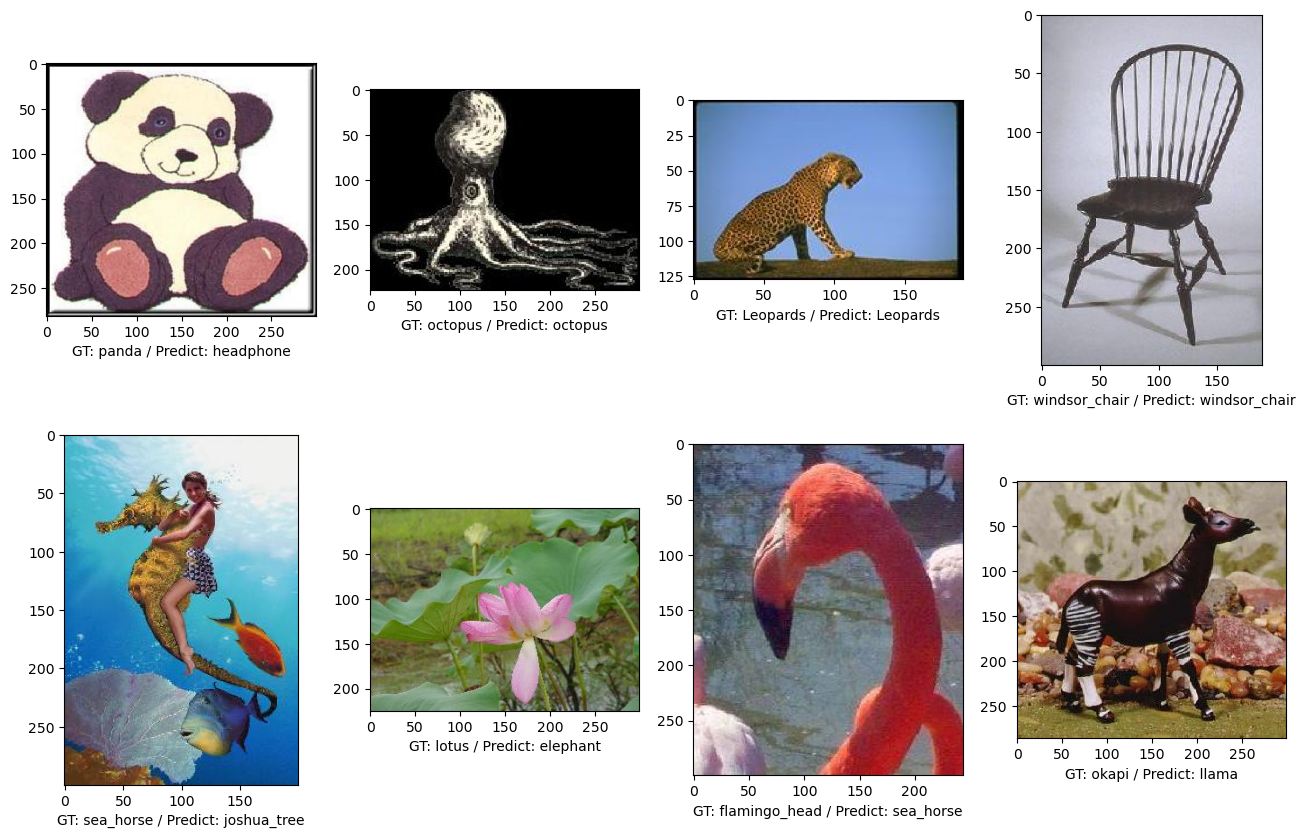

In [16]:
# Show 8 random images
plt.figure(figsize=(16,10))
for i, idx in enumerate(random.sample(range(len(classes)), 8)):
    # Extract Image Descriptor
    fpath = random.sample(test_image_ll[idx], 1)[0]
    img = cv2.imread(fpath, cv2.IMREAD_GRAYSCALE)
    bow = getImageDescriptor(img)
    
    # Hellinger's kernel
    temp = np.sqrt(bow)
    temp -= np.average(temp)
    if np.std(temp) != 0:
        temp /= np.std(temp)
    
    # Prediction
    test_preds = (int)(svm.predict(temp.reshape((1,12000)))[1][0,0])
    
    plt.subplot(2, 4, i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(fpath), cv2.COLOR_BGR2RGB))
    plt.xlabel("GT: %s / Predict: %s" % (classes[idx], classes[test_preds]))

## Practice: Classification for your own image

Choose Classify your own test image using our classification.

- Place your image in the path where this notebook can access
- Load an image as grayscale
- Extract Dense SIFT BoW with `getImageDescriptor()`
- Normalize the bow with Hellinger's kernel
- Predict using the SVM classifier we have trained so far(`svm` instance)

Text(0.5, 0, 'Prediction: ceiling_fan')

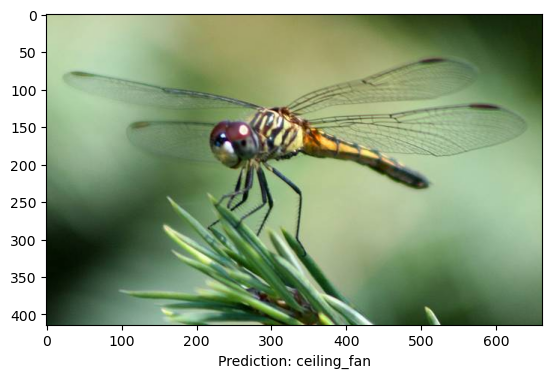

In [19]:
img_fpath = 'dragonfly.jpg'  # Path to your own image
img = cv2.imread(img_fpath, cv2.IMREAD_GRAYSCALE)

#================ YOUR CODE HERE ===================
bow = getImageDescriptor(img)
    
# Hellinger's kernel
temp = np.sqrt(bow)
temp -= np.average(temp)
if np.std(temp) != 0:
    temp /= np.std(temp)
    
# Prediction
prediction = (int)(svm.predict(temp.reshape((1,12000)))[1][0,0])  # Predicted class of your image
#===================================================

plt.imshow(cv2.cvtColor(cv2.imread(img_fpath), cv2.COLOR_BGR2RGB))
plt.xlabel("Prediction: %s" % classes[prediction])

In [ ]:
# Desired output